In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 移流方程式

In [ ]:
def advection(u0, x, t, v=1.0, method="F"):
    dt, dx, ans = t[1]-t[0], x[1]-x[0], [u0]
    for i in range(len(ts)-1):
        if method=="F":   # u[i+1]-u[i]
            du = np.roll(u0, -1) - u0
        elif method=="C": # (u[i+1]-u[i-1])/2
            du = (np.roll(u0,-1) - np.roll(u0,1))/2      
        elif method=="B": # u[i]-u[i-1]
            du =  u0 - np.roll(u0, 1)
        du[0], du[-1] = 0, 0 # 境界条件で端を補正
        u1 = u0 - v*dt*du/dx
        ans.append(u1)
        u0 = u1
    return np.array(ans)

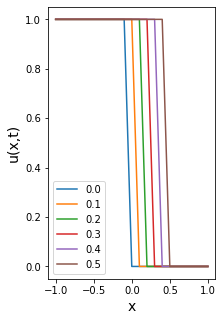

In [ ]:
Nx, Nt = 20, 5
x0 = np.linspace(-1,1,Nx+1) # dx = 0.1
ts  = np.linspace(0,0.5,Nt+1) # dt = 0.1
u0 = 1 * (x0 < 0)
u = advection(u0, x0, ts, 1.0, "B")
plt.figure(figsize=(3,5))
for i, t in enumerate(ts):
    plt.plot(x0, u[i], label=str(np.round(t,3)))
plt.xlabel("x", fontsize=14)
plt.ylabel("u(x,t)", fontsize=14)
plt.legend()
plt.show()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PythonText_Figures


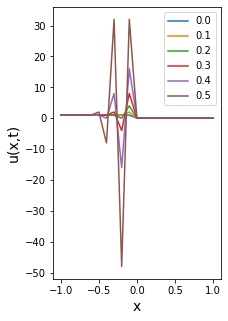

In [ ]:
# 図の保存用(テキストには含まれない)
u = advection(u0, x0, ts, 1.0, "F")
plt.figure(figsize=(3,5)) # 図のサイズ(横,縦)を指定
for i, t in enumerate(ts):
    plt.plot(x0, u[i], label=str(np.round(t,3)))
plt.legend()
plt.xlabel("x", fontsize=14)
plt.ylabel("u(x,t)", fontsize=14)
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/PythonText_Figures
plt.savefig("figure_pde_1F.pdf", bbox_inches='tight')

# 古典phi4理論のソリトンダイナミクス

In [ ]:
from scipy.integrate import solve_ivp
def phi4(t, x, h, N, bx):
    p, q = x[:N], x[N:] # [0,N-1]をphi, それ以降をpsiとする
    d2p = np.concatenate([[bx[0]],p,[bx[1]]])
    d2p = np.diff(d2p,2)/h**2  # 2次差分をとる関数
    # 端を固定するため, 両端にbx[0]とbx[1]を足してある.
    vp = - 2*(p**2-1)*p
    return np.append(q, d2p+vp) # 2*nx次元ベクトルに戻して返す

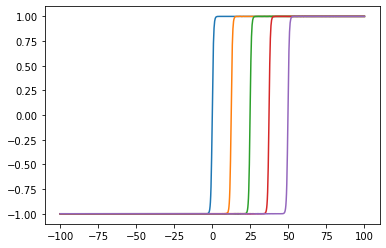

In [ ]:
L, N, u = 100, 1001, 0.5  # パラメータの定義
x, h = np.linspace(-L, L, N, retstep=True)
t = np.linspace(0,100,5)
l   = lambda u: np.sqrt(1-u**2)
p0 = lambda x, x0, u: np.tanh((x-x0)/l(u))         # phiの初期値
q0 = lambda x, x0, u: -u/l(u)/np.cosh((x-x0)/l(u))**2 # psiの初期値
x0 = np.append(p0(x,0,u), q0(x,0,u))
sol = solve_ivp(phi4,(0,100),x0,'RK45',t,args=(h,N,(-1,1)))
plt.plot(x, sol.y[:N])       # phiのみプロット
plt.show()

In [ ]:
t = np.linspace(0,200,200)
p0_col = p0(x,-20,u) - p0(x,20,-u) - 1
q0_col = q0(x,-20,u) - q0(x,20,-u)
x0 = np.append(p0_col, q0_col)
sol = solve_ivp(phi4,(0,200),x0,'RK45',t,args=(h,N,(-1,-1)))

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
p = sol.y[N:] # psiのみプロット
fig = plt.figure()
ims = []
for i in range(200):
    im = plt.plot(x, p.T[i], c="red")
    ims.append(im)
anim = animation.ArtistAnimation(fig, ims, interval=100)
rc('animation', html='jshtml')
plt.close()
anim

Output hidden; open in https://colab.research.google.com to view.

# ポアソン方程式

In [ ]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import csr_matrix
nx = 99 # xy平面を100x100で分割する => phiの次元は99x99
d_csr = csr_matrix(np.eye(nx,k=1)+np.eye(nx,k=-1))
 # 一次元方向のインデックスをシフトする疎行列(端は無視)
def shift(v):
    v = v.reshape((nx,nx))     # ベクトル => 行列への変換
    v = (d_csr*v+v*d_csr)/4  # x, yそれぞれの方向をシフト
    return v.flatten()          # ベクトルに戻して返す
A = LinearOperator((nx**2, nx**2), matvec=shift)

In [ ]:
b = np.zeros((nx,nx))
b[:,-1] = -1/4 #  y=1の辺に対する条件. 他は0なのでそのままで良い.
b = b.reshape(nx**2)

0.04410426086716965
0.0013462346958076177
0.0008394777024521252
0.0006424414961333809
0.0005343444062068507
0.0004651592160310406
0.0004169688527294695
0.0003816354373226926
0.00035476731322048826
0.00033367443019459566


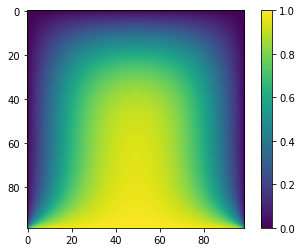

In [ ]:
x0 = np.ones(nx**2)             # 初期電位は全領域で1とした
for i in range(1000):
    x1 = A*x0 - b    # LinearOperatorを用いた行列ベクトル積
    if i % 100 == 0: # 100ステップ毎に誤差を出力
        print(np.linalg.norm(x0-x1)/np.linalg.norm(x1))
    x0 = x1
plt.imshow(x0.reshape((nx,nx)).T, vmin=0, vmax=1)
 # 行は縦,列は横のインデックスなので, 通常の2次元プロットの描き方
 # だとiがy,jがxと対応する. これを補正するため転置している. 
plt.colorbar()
plt.show()

In [ ]:
def user_cg(A, b, x0):
    # 自作の共役勾配法関数. (6.6)-(6.8)式とその周辺を参照
    r0 = b - A*x0
    p0 = r0
    for i in range(500):
        alpha = np.dot(r0,p0)/np.dot(p0,A*p0)
        x1 = x0 + alpha*p0
        r1 = r0 - alpha*A*p0
        beta = np.dot(r1,r1)/np.dot(r0,r0)
        p1 = r1 + beta*p0
        if np.linalg.norm(x1-x0)/np.linalg.norm(x1) < 1e-5:
            break
        x0, r0, p0 = x1, r1, p1
    return x1, np.linalg.norm(x1-x0)/np.linalg.norm(x1), i

In [ ]:
def shift(v):
    v = v.reshape((nx,nx))
    v = (d_csr*v+v*d_csr)/4 - v # (8.11)式の左辺の計算に対応
    return v.flatten()
A = LinearOperator(shape=(nx**2, nx**2), matvec=shift)

9.737514603334868e-06 190


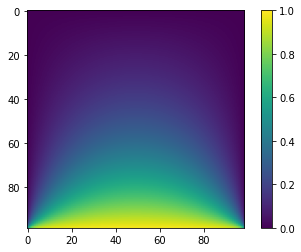

In [ ]:
x, e, n = user_cg(A, b, np.ones(nx**2))
print(e, n)  # 誤差と収束にかかったステップの表示
plt.imshow(x.reshape((nx,nx)).T, vmin=0, vmax=1)
plt.colorbar()
plt.show()

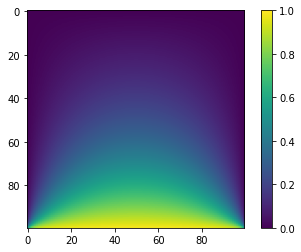

In [ ]:
# scipy.sparse.linalg.cgを使ったもの(テキストには含まれない)
from scipy.sparse.linalg import LinearOperator, cg
x0 = np.ones(nx**2)
x = cg(A, b, x0, maxiter=250)
plt.imshow(x[0].reshape((nx,nx)).T, vmin=0, vmax=1)
plt.colorbar()
plt.show()

# 1電子原子の動径波動関数

In [2]:
rmax, M, l, Z = 50, 1000, 1, 2
r, h = np.linspace(rmax, 0, M, endpoint=False, retstep=True)
  # retstep=Trueとすると, 配列と刻み幅のタプルを返す
r, h = r[::-1], -h # rを逆順に変更(結果には影響しない)

In [3]:
from scipy.sparse import diags, linalg
I = np.ones(M)
d2p = 0.5 * diags([-2*I, I, I], (0, -1, 1)) / h**2
  # 第一引数に対角要素に入れたいベクトル(の組)を渡す
  # 第二引数でそれぞれのオフセットを指定
pot = diags(-Z/r) # 指定がなければオフセットなしの対角行列を作る
ang = diags(0.5*l*(l+1)/r**2)
A = - d2p + pot + ang
eig, vec = linalg.eigsh(A, k=5, which="SA")

In [4]:
# 解のチェック(テキストには含まれない)
print(eig)

[-0.50010433 -0.2222703  -0.12502477 -0.08001412 -0.05549747]


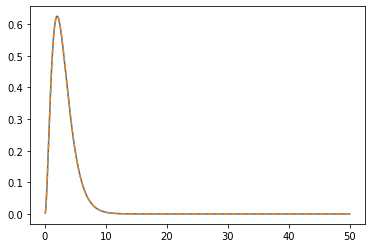

In [5]:
from scipy.integrate import simps
p21 = vec.T[0]
p21 = np.sign(p21[1])*p21/np.sqrt(simps(p21**2, r))
I = Z**2.5 * r**2 * np.exp(-Z*r/2) / np.sqrt(24)
plt.plot(r, p21)
plt.plot(r, I, ls='dashed')
plt.show()

# 発展問題(ポアソン方程式)

In [ ]:
from scipy.sparse import csr_matrix
# パラメータの定義(拡散係数と1次元方向の分割数)
D, nx = 1, 20 
# 初期状態(2次元平面の中心にピークを持つデルタ関数)の設定
x0 = np.zeros((nx,nx))
x0[nx//2,nx//2] = nx*nx
x0 = x0.flatten()
# 2階微分演算子の定義
d2 = np.eye(nx,k=1) + np.eye(nx,k=-1) - 2*np.eye(nx)
d2[0,nx-1], d2[nx-1,0] = 1, 1       # 周期境界条件に対応
d2_csr = nx**2 * D * csr_matrix(d2) # dx = 1/nx
Lap = lambda x, d2: d2*x + x*d2
def diffusion(t, x, nx, d2):
    return Lap(x.reshape(nx,nx), d2).flatten()

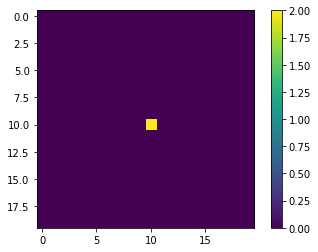

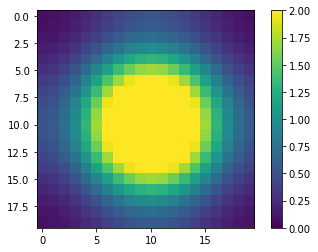

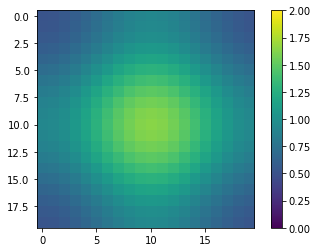

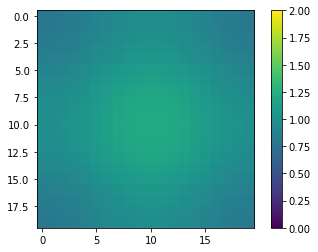

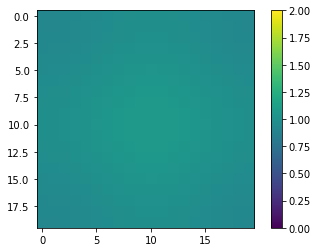

In [ ]:
from scipy.integrate import solve_ivp
t = np.linspace(0,0.1,5)
sol = solve_ivp(fun=diffusion, t_span=(t[0], t[-1]), y0=x0, \
                t_eval=t, args=(nx, d2_csr))
for i in range(len(t)):
    y = (sol.y.T[i]).reshape(nx,nx)
    plt.imshow(y, vmin=0, vmax=2)
    plt.colorbar()
    plt.show()

In [ ]:
def CahnHilliard(t, x, nx, d2, gam):
    y = x.reshape(nx,nx)
    return Lap(y**3-y+gam*Lap(y, d2), d2).flatten()

In [ ]:
x0 = np.zeros((nx,nx)) + 0.01*(np.random.rand(nx,nx)-0.5)
x0 = x0.flatten()
t = np.linspace(0,1,20)
sol = solve_ivp(fun=CahnHilliard, t_span=(t[0],1), y0=x0, \
     method='RK45', t_eval=t, args=(nx, d2_csr,-0.001))

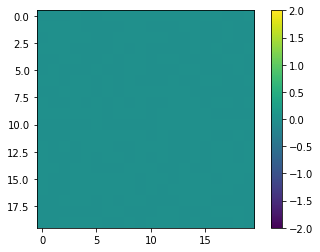

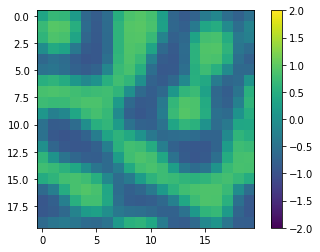

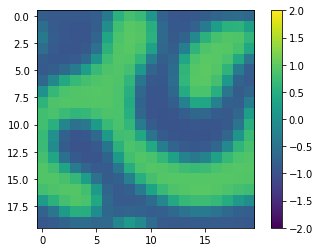

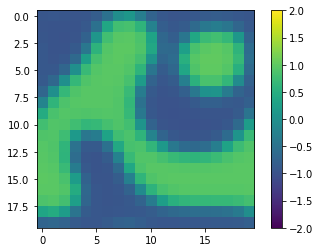

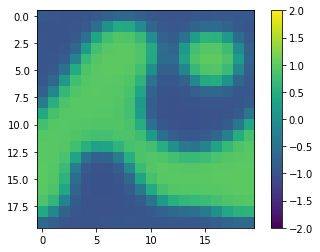

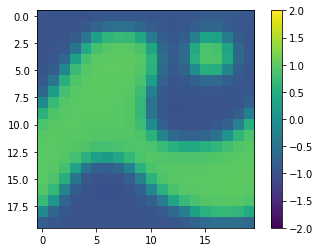

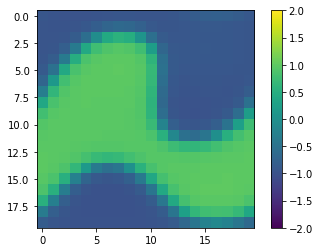

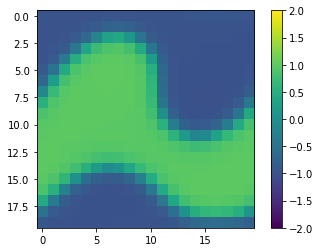

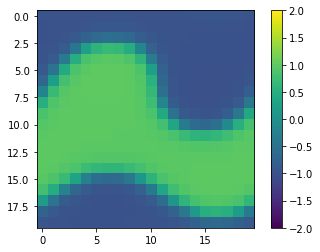

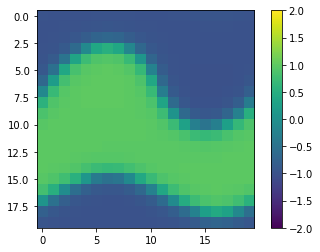

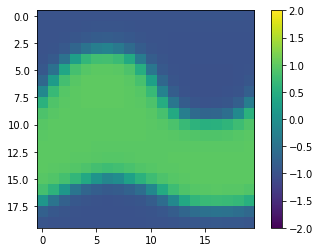

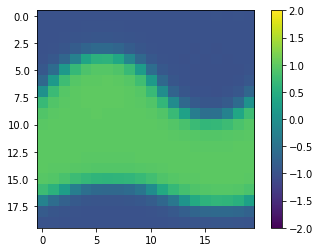

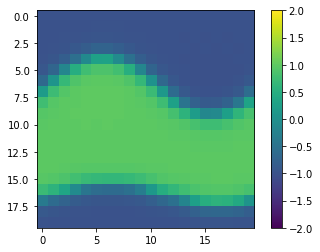

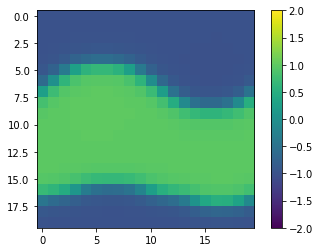

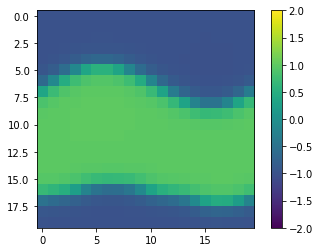

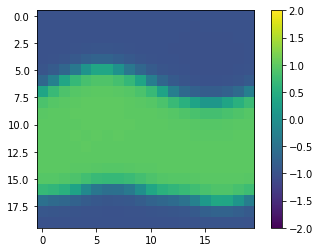

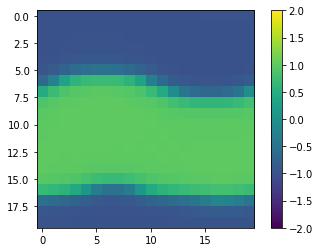

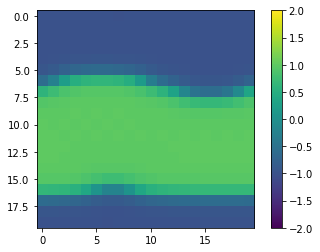

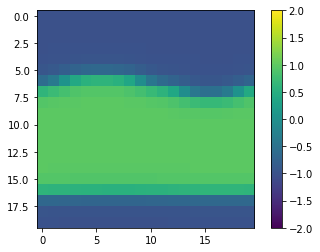

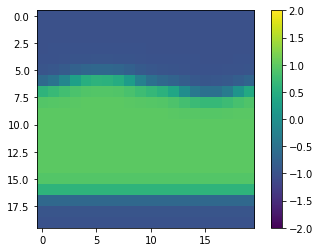

In [ ]:
# テキストには含まれない
for i in range(len(t)):
    y = (sol.y.T[i]).reshape(nx,nx)
    plt.imshow(y, vmin=-2, vmax=2)
    plt.colorbar()
    plt.show()

# 発展問題(一電子原子の動径波動関数)

In [6]:
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp, simps
ptol = 1e-9
rmin = lambda l: ptol**(1/(l+1))
rmax = lambda E: -np.log(ptol)/np.sqrt(-2*E)
rc = lambda E, Z: -Z/E
def RS(x, y, E, l, Z):
    P, Q = y[0], y[1]
    p = -Z/x - E + 0.5*l*(l+1)/x**2
    return Q, 2*p*P

In [7]:
def Connection(E, l, Z):
    x0 = [ptol, (l+1)*rmin(l)**l]
    so = solve_ivp(RS, (rmin(l), rc(E,Z)), x0, 'RK45', \
       [rc(E,Z)], args=(E, l, Z), rtol=1e-10, atol=1e-10)
    x0 = [ptol, -np.sqrt(-2*E)*ptol]
    si = solve_ivp(RS, (rmax(E), rc(E,Z)), x0, 'RK45', \
       [rc(E,Z)], args=(E, l, Z), rtol=1e-10, atol=1e-10)
    nume = so.y[1,-1]/so.y[0,-1] - si.y[1,-1]/si.y[0,-1]
    deno = so.y[1,-1]/so.y[0,-1] + si.y[1,-1]/si.y[0,-1]
    return nume / deno

In [8]:
n = 1
x0 = eig[n]-(eig[n]-eig[n-1]) * 0.2
x1 = eig[n]+(eig[n+1]-eig[n]) * 0.2
sol = root_scalar(Connection, bracket=(x0, x1), \
      method="bisect", args=(l, Z), rtol=1e-9)
print(sol.root)

-0.22222221740222806


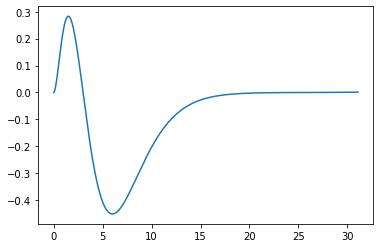

In [9]:
# 固有ベクトルの計算(テキストには含まれない)
E = sol.root
x_eval = np.linspace(rmin(l), rmax(E), M)
x0 = [ptol, (l+1)*ptol]
vec = solve_ivp(RS, (rmin(l), rmax(E)), x0, 'RK45', x_eval, args=(E, l, Z), rtol=1e-10, atol=1e-10).y[0]
vec = vec/np.sqrt(simps(vec**2, x_eval))*np.sign(vec[0])
plt.plot(x_eval, vec)
plt.show()

In [10]:
# 変数変換を行なったもの(テキストには含まれない)
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp, simps
r, x = lambda x: np.exp(x), lambda r: np.log(r)
def RS(x, y, E, l, Z):
    P, Q = y[0], y[1] 
    p = -2*r(x)**2*E + l*(l+1) - 2*r(x)*Z
    return Q, p*P + Q
ptol = 1e-9
r, x = lambda x: np.exp(x), lambda r: np.log(r)
xmin = lambda l: x((ptol)**(1/(l+1)))
xmax = lambda E: x(-x(ptol)/np.sqrt(-2*E))
xc = lambda E, Z: x(-Z/E)
def Connection(E, l, Z):
    x0 = [ptol, (l+1)*ptol]
    so = solve_ivp(RS, (xmin(l), xc(E,Z)), x0, 'RK45', [xc(E,Z)], args=(E, l, Z), rtol=1e-10, atol=1e-10)
    x0 = [ptol, x(ptol)*ptol]
    si = solve_ivp(RS, (xmax(E), xc(E,Z)), x0, 'RK45', [xc(E,Z)], args=(E, l, Z), rtol=1e-10, atol=1e-10)
    nume = so.y[1][-1]/so.y[0][-1] - si.y[1][-1]/si.y[0][-1]
    deno = so.y[1][-1]/so.y[0][-1] + si.y[1][-1]/si.y[0][-1]
    return nume / deno
n = 2
x0 = eig[n]-(eig[n]-eig[n-1]) * 0.2
x1 = eig[n]+(eig[n+1]-eig[n]) * 0.2
sol = root_scalar(Connection, bracket=(x0, x1), method="bisect", args=(l, Z), rtol=1e-9)
print(sol.root)

-0.12499999987313094
